2.1 Data exploration of Point Of Interest

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('NYC_POIs/pois_all_info',delimiter="\t",dtype=str)
print(np.shape(df))
ny = np.genfromtxt("NYC_POIs/ny_municipality_pois_id.csv",dtype=str)

filtered_df = df[df["@id"].isin(ny)]






(77884, 9)


2: Number of nan

In [4]:
n_nan = filtered_df.isna().sum(axis=1)
print(n_nan)

0        4
1        4
2        3
3        3
4        4
        ..
76980    5
76981    5
76982    5
76983    5
76984    5
Length: 53521, dtype: int64


3: Distribution of the POI types 

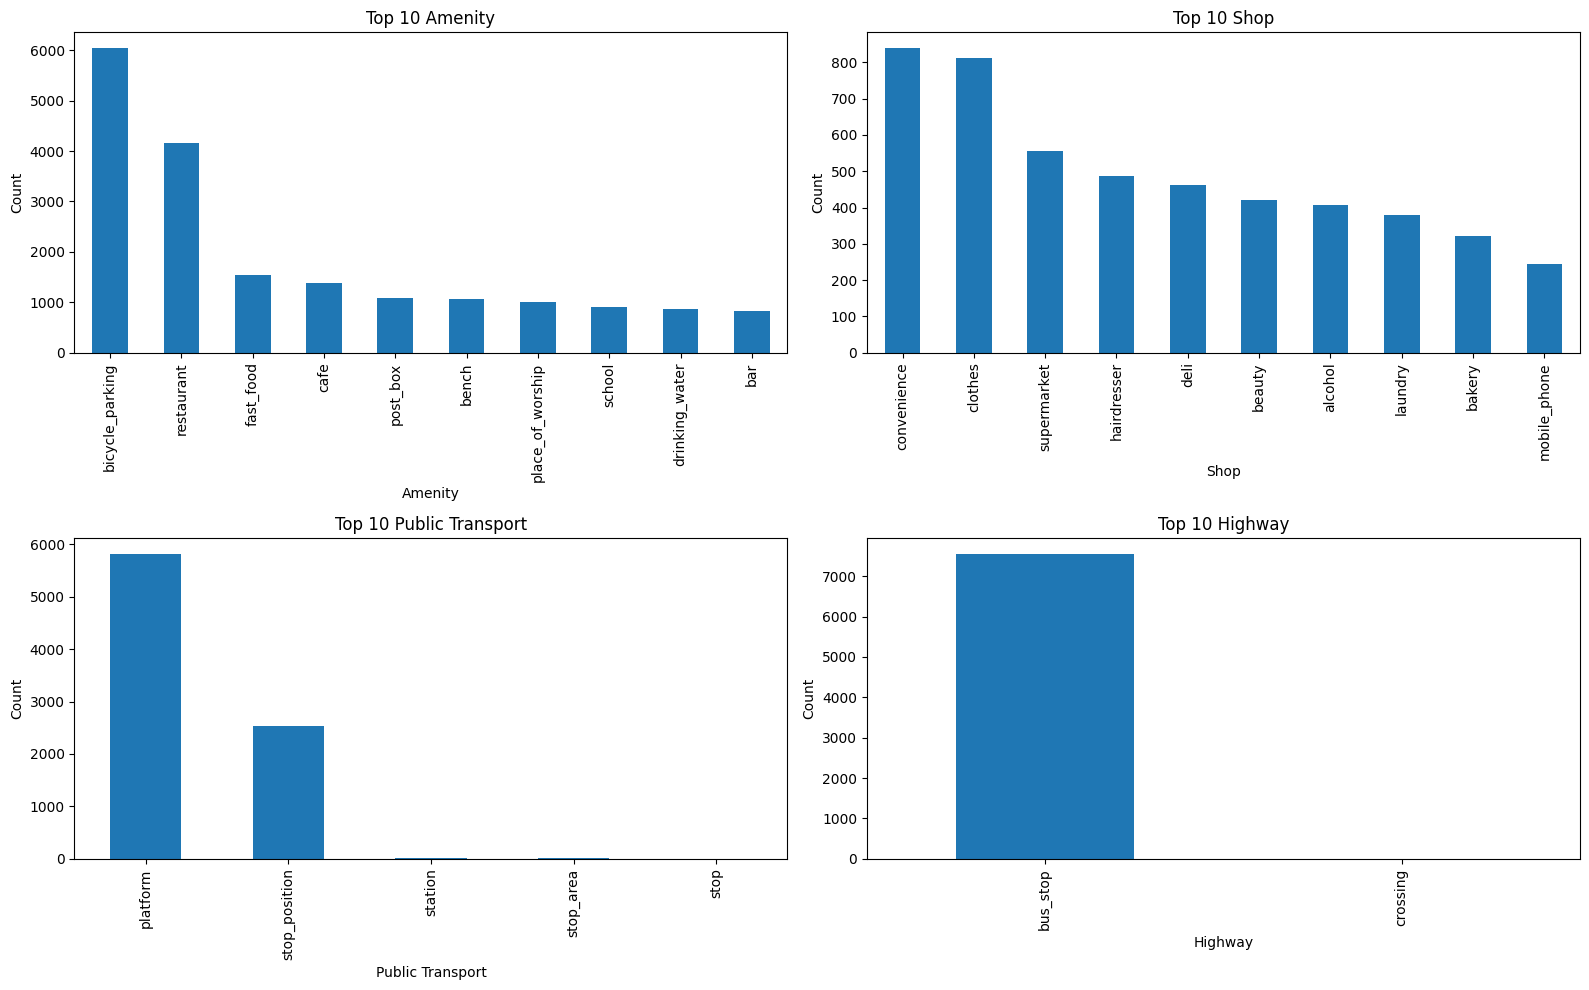

In [5]:
import matplotlib.pyplot as plt

columns = ['amenity', 'shop', 'public_transport', 'highway']
titles = ['Amenity', 'Shop', 'Public Transport', 'Highway']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(columns):
    data = filtered_df[col].dropna()
    top_values = data.value_counts().iloc[:10]
    top_values.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Top 10 {titles[i]}')
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

#highway are useless


Point 4:
To do this we need to setup a color map to understand the content

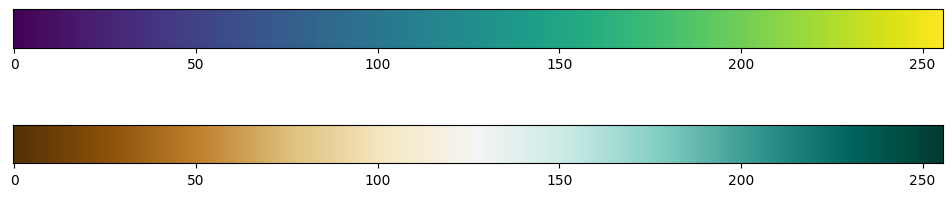

In [6]:
from matplotlib.cm import get_cmap

x = np.linspace(0,1,256) #color scale
x= np.vstack((x,x))#replicate content of the initial vector

fig,ax = plt.subplots(nrows=2, figsize=(12,2) )#create 2 sublots
plt.subplots_adjust(hspace=2)
#fill the plot with color scales (already existing in matplotlib)

for ax,name in zip(ax, ["viridis", "BrBG"]):
    ax.imshow(x,aspect="auto", cmap=plt.get_cmap(name))
    ax.grid(False)
    ax.get_yaxis().set_visible(False)

In [7]:
class Map:
    def __init__(self,df):
        self.pois_df=df
        self.lat_min= float(df["@lat"].min())
        self.lat_max= float(df["@lat"].max())
        self.lon_min= float(df["@lon"].min())
        self.lon_max= float(df["@lon"].max())
        print(self.lat_min,self.lat_max,self.lon_min,self.lon_max)

    def plot_map(self):
        fig,ax = plt.subplots(figsize=(12,12))
        nyc_image = plt.imread("NYC_POIs/New_York_City_Map.PNG")
        ax.imshow(nyc_image,extent=[self.lon_max, self.lon_min, self.lat_min, self.lat_max],aspect='equal') #lon is the contrary because it is negative
        ax.grid(False)
        
        
        return ax

    def plot_pois(self,ax, category, mask,n_grid=0):
        df = self.pois_df.loc[mask]

        types= df[category].unique()
        cmap= get_cmap("viridis")
        colors=cmap(np.linspace(0,1,len(types)))
        for i,t in enumerate(types):
            df_t = df.loc[df[category]== t ]
            c= [colors[i]] * df_t.shape[0]
            
            ax.scatter(df_t["@lon"].astype(float), df_t["@lat"].astype(float), c=c, label=t)
        
        ax.legend()
        
        if (n_grid!=0):
            lon_grid = np.linspace(self.lon_max, self.lon_min, n_grid)  
            lat_grid = np.linspace(self.lat_min, self.lat_max, n_grid)  
            
            #vertical
            for lon in lon_grid:
                ax.axvline(x=lon, color='white', linestyle='--', linewidth=1)
            
            #horizontal
            for lat in lat_grid:
                ax.axhline(y=lat, color='white', linestyle='--',  linewidth=1)
        return  ax
    
    def return_grid(self,n_grid):
        lon_grid = np.linspace(self.lon_max, self.lon_min, n_grid)  
        lat_grid = np.linspace(self.lat_min, self.lat_max, n_grid) 
        return lon_grid,lat_grid
    
    def getlats(self):
        return self.lat_min,self.lat_max
    
    def getlons(self):
        return self.lon_min,self.lon_max


        
    

In [8]:
def get_top_category(df,category , number):
    data = df[category].dropna()
    top_values = data.value_counts().iloc[:number].index
    filtered_top_df = filtered_df[filtered_df[category].isin(top_values)]
    return filtered_top_df
    


In [9]:
def show_category_on_map(df,column,number,n_grid=0):
    top_freq = get_top_category(df,column,number)
    ny_map  = Map(df)

    ax= ny_map.plot_map()
    mask = df[column].isin(top_freq[column].unique())

    ny_map.plot_pois(ax,column,mask,n_grid)
    return ny_map

40.5024225 40.9139069 -73.7001124 -74.2527909


C:\Users\mauri\AppData\Local\Temp\ipykernel_5556\1965369094.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap= get_cmap("viridis")


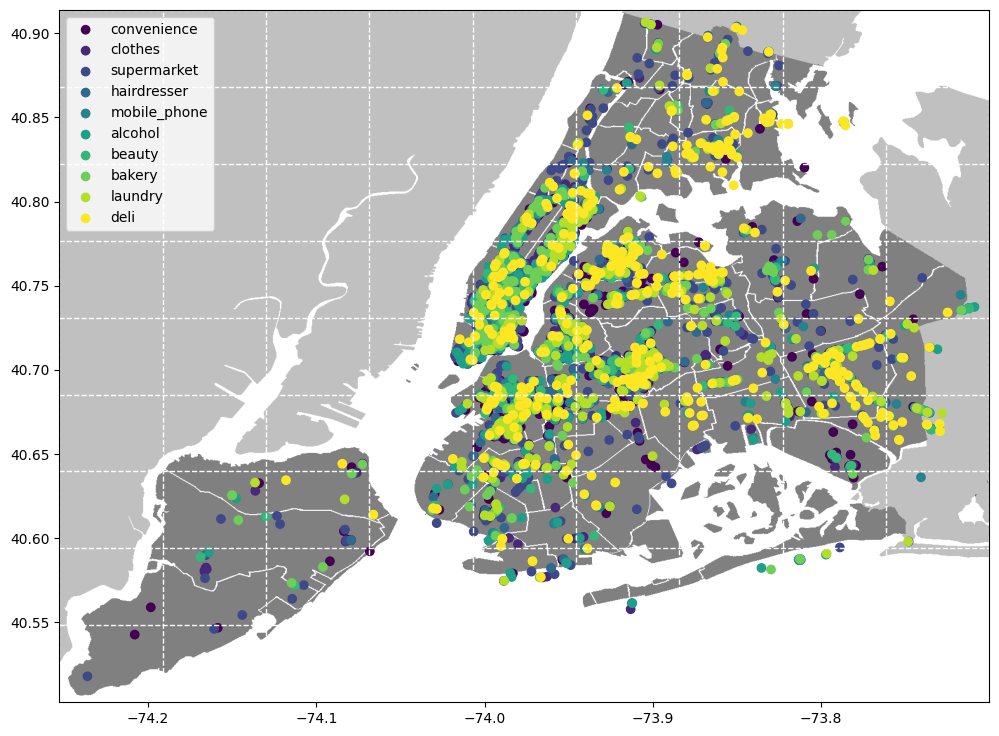

In [10]:
n=10
ny_map = show_category_on_map(filtered_df,"shop",10,n)




In [11]:
def grid_pois(df,lon_grid,lat_grid):
    lats = df["@lat"].astype(float)
    lons = df["@lon"].astype(float)

    lats_index = np.digitize(lats,lat_grid)-1
    lons_index = np.digitize(lons,lon_grid)-1
   
    return (lats_index,lons_index)

In [12]:
lon_grid, lat_grid = ny_map.return_grid(n) 
lats_index, lons_index = grid_pois(filtered_df,lon_grid,lat_grid) 
grid_df = filtered_df.copy()
grid_df["grid_indexes"] = list(zip(lats_index, lons_index)) #to create tuples

print(grid_df["grid_indexes"])

0        (6, 4)
1        (5, 4)
2        (7, 7)
3        (7, 6)
4        (4, 7)
          ...  
76980    (5, 8)
76981    (5, 8)
76982    (5, 8)
76983    (5, 8)
76984    (5, 8)
Name: grid_indexes, Length: 53521, dtype: object


6.

In [ ]:
def create_df(df,category)
    lon_grid = np.linspace(ny_map.getlons()[1], ny_map.getlons()[0], n)  
    lat_grid = np.linspace(ny_map.getlats()[0], ny_map.getlats()[1], n) 

    print(lon_grid,lat_grid)


    X, Y = np.meshgrid(lon_grid, lat_grid)
        
    combinations = np.dstack([X, Y]).reshape(-1, 2)
    np.shape(combinations)



[-74.2527909  -74.19138218 -74.12997346 -74.06856473 -74.00715601
 -73.94574729 -73.88433857 -73.82292984 -73.76152112 -73.7001124 ] [40.5024225  40.54814299 40.59386348 40.63958397 40.68530446 40.73102494
 40.77674543 40.82246592 40.86818641 40.9139069 ]


(100, 2)